## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [48]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import math
import random

from matplotlib import pyplot as plt
from scipy.signal import find_peaks


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def LoadTroikaReferenceFile(ref_fl):
    """
    Loads and extracts signals from a troika ref data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        hr_refs = LoadTroikaReferenceFile(data_fls[0])

    Args:
        ref_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy array hr values.
    """
    hr_array = []
    data = sp.io.loadmat(ref_fl)
    for i in range(data['BPM0'].shape[0]):
        hr_array.append(data['BPM0'][i][0])
    
    return np.array(hr_array)


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, pass_band, fs=125):
    """
    Performs a bandpass filter on a signal

    Args:
        signal:  a numpy array containing a series of signal values.
        pass_band:  a tuple representing the target frequency range in hz (e.g. (1, 4))
        fs: the signal's sample rate in hz

    Returns:
        The filtered signal.
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)
    
def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Runs the algorithim to estimate pulse rates from ppg and acceleromter signals

    Args:
        data_fl: Name of a .mat files that contains signal data
        ref_fl: Name of a .mat files that contains reference data

    Returns:
        per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    """
    # Load data
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    hr_refs = LoadTroikaReferenceFile(ref_fl)

    #define some constants
    fs = 125              # The sample rate in hz
    nfft = fs*8           # The number of data points used in each block for the FFT.
    noverlap = fs*6       # The number of points of overlap between blocks.
    pass_band = (.67, 4)  # A frequency range for the Bandpass filter

    # Lists to store the results
    hr_estimates = []  # A list to store the HR estimates
    errors = []        # A list to store the HR errors
    confidence = []    # A list to store the confidence levels
    
    print(data_fl)     # Display the file being processed

    #apply a bandpass filter
    ppg = BandpassFilter(ppg, pass_band, fs)  #bandpass range is between 60 and 240 bpm
    accx = BandpassFilter(accx, pass_band, fs)
    accy = BandpassFilter(accy, pass_band, fs)
    accz = BandpassFilter(accz, pass_band, fs)
    acc = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))

    #use the matplotlib specgram function to perform fft traforms on the signals
    ppg_spectrum, ppg_freqs, times, ppg_image = plt.specgram(ppg, NFFT=nfft, Fs=fs, noverlap=noverlap)
    accx_spectrum, accx_freqs, timesx, accx_image = plt.specgram(accx, NFFT=nfft, Fs=fs, noverlap=noverlap)
    accy_spectrum, accy_freqs, timesy, accy_image = plt.specgram(accy, NFFT=nfft, Fs=fs, noverlap=noverlap)
    accz_spectrum, accz_freqs, timesz, accz_image = plt.specgram(accz, NFFT=nfft, Fs=fs, noverlap=noverlap)

    #Iterate through the 8-second windows, advancing 2 seconds with each iteration
    for i in range(len(times)):
        hr_ref = hr_refs[i]  # the label (correct) HR for calculating error amount

        #get an array of ppg and acc indices from the sorted from largest magnitude to the smallest
        max_spec_indexes = np.flip(np.argsort(ppg_spectrum[:,i]), axis=0)
        max_accx_freq = accx_freqs[np.argmax(accx_spectrum[:,i])]
        max_accy_freq = accy_freqs[np.argmax(accy_spectrum[:,i])]
        max_accz_freq = accz_freqs[np.argmax(accz_spectrum[:,i])]
        
        freq_diff = .15  #maximum difference in frequency between ppg an acc sensors to be considered interfereing with each other. Value arrived at by trial-and-error.
        hr = ppg_freqs[max_spec_indexes[0]] * 60  #most likely HR that will be used if we don't find acc frequencies that interfere with it.
        total_ppg_spectrum = np.sum(ppg_spectrum[:,i])
        this_confidence = ppg_spectrum[:,i][max_spec_indexes[0]] / total_ppg_spectrum
        
        # Iterate through the 5 ppg frequencies with the largest magnitude.
        # If we find an acc frequency that is close to the ppg frequency, it is most likely interfereing with the ppg sensor and 
        # we should look to the next ppg frequency with the next largest magnitude.  If we go through all 5, just use the ppg frequency
        # with the highest magnitude.
        for j in range(0, 6):
            this_max_freq = ppg_freqs[max_spec_indexes[j]]
            if abs(this_max_freq - max_accx_freq) < freq_diff or abs(this_max_freq - max_accy_freq) < freq_diff or abs(this_max_freq - max_accz_freq) < freq_diff:
                # An acc frequency (body movement) was found that is likely causing this readingfrom the ppg sensor.  Skip to the next one.
                continue
            else:
                # No interfering acc frequencies were found.  Use the current ppg frequency to calculate HR.
                hr = this_max_freq * 60 
                this_confidence = ppg_spectrum[:,i][max_spec_indexes[j]] / total_ppg_spectrum
                break
        
        hr_estimates.append(hr)

        errors.append(abs(hr - hr_ref))
        confidence.append(this_confidence)

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return np.array(errors), np.array(confidence)

./datasets/troika/training_data/DATA_01_TYPE01.mat
./datasets/troika/training_data/DATA_02_TYPE02.mat
./datasets/troika/training_data/DATA_03_TYPE02.mat
./datasets/troika/training_data/DATA_04_TYPE01.mat
./datasets/troika/training_data/DATA_04_TYPE02.mat
./datasets/troika/training_data/DATA_05_TYPE02.mat
./datasets/troika/training_data/DATA_06_TYPE02.mat
./datasets/troika/training_data/DATA_07_TYPE02.mat
./datasets/troika/training_data/DATA_08_TYPE02.mat
./datasets/troika/training_data/DATA_10_TYPE02.mat
./datasets/troika/training_data/DATA_11_TYPE02.mat
./datasets/troika/training_data/DATA_12_TYPE02.mat
11.892270997991398


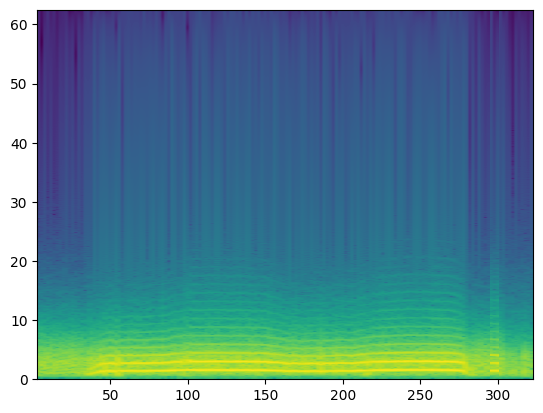

In [49]:
print(Evaluate())

## Scratch code to figure out the specgram method

loading:  ./datasets/troika/training_data/DATA_01_TYPE01.mat
ppg_spectrum.shape:  (501, 148)
ppg_freqs.shape:  (501,)
times.shape:  (148,)
ppg_freqs[:10]:  [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.    1.125]


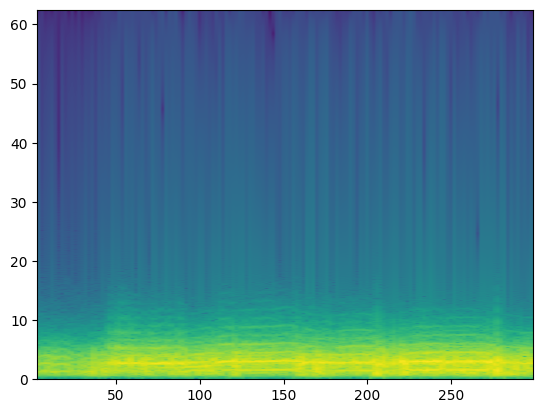

In [3]:
data_files, reference_files = LoadTroikaDataset()
#print(data_files)
#print(reference_files)

data_file = data_files[0]
print("loading: ", data_file)
sig_data = LoadTroikaDataFile(data_file)
ppg, accx, accy, accz = LoadTroikaDataFile(data_file)
acc_total = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))

fs = 125  
pass_band = (.67, 4)
ts = np.arange(len(accx)) / fs
nfft = fs*8  #The number of data points used in each block for the FFT.
noverlap = fs*6  #The number of points of overlap between blocks.

filtered_ppg = BandpassFilter(ppg, pass_band, fs)
ppg_spectrum, ppg_freqs, times, ppg_image = plt.specgram(filtered_ppg, NFFT = nfft, Fs=fs, noverlap=noverlap)
print("ppg_spectrum.shape: " , ppg_spectrum.shape)
print("ppg_freqs.shape: " , ppg_freqs.shape)
print("times.shape: " , times.shape)

print("ppg_freqs[:10]: " , ppg_freqs[:10])


for i in range(len(times)):
    time = times[i]
    max_idx = np.argmax(ppg_spectrum[:,i])
    max_freq = ppg_freqs[max_idx]
    #print("time: {}, freq: {}, HR: {}".format(time, max_freq, max_freq*60))

# print(ppg_spectrum[:,10])
# max_idx = np.argmax(ppg_spectrim[:,10])
# print(ppg_freqs[max_idx])


# Project Write-up
## Code Description 
I tried to stick with the starter code.  The first cell contains all of the code necessary to extract the information from the files, interpret the PPG and ACC data, and produce that output necessary to allow the evaluate method to run.

The second cell runs the Evaluate() method and displays the results.  

The other notebook (pulse_rate_starter_fft) contains a lot of code trying to figure out how to do this using FFTs.  Knowledge gained there was applied to this notebook's implementation using the matplotlib specgram.

## Data Description 
The data includes the output from an ECG sensor, a PGG sensor and a 3-axis accelerometer.  The algorithim uses data form teh PPG sensor and accelerometer to estimate heart rate.  Errors in the algorithim are determined by comparing the algorithim's output to the heart rate determined buy the ECG sensor.  data was collected from the PPG and accelerometer sensors at a 125 HZ sample rate.

The data was collected from 12 sessions from 11 subjects.  Each session was 5 minutes long during which the subject woudl rest, jog, and run at various speeds on a treadmill.  

The shortcomings of the data are that it comes from a very controlled environment under the supervision of staff collecting the metrics.   The data may not reflect what would happen in real-world scenarios.


## Algorithim Description 
The following steps produce the data for the project:
 - The algorithim first reads the data file and creates numpy arrays of the PPG sensor's output and the 3-axis accelerometer. 
 - A bandpass filter was applied to all four signals to remove noise that is ouside of the range of data we are interested in (less than 40 BPM, more than 240 BPM)
 - The mpedgram method was used to create a fast fourier transform (FFT) in 8-second segments, each spaced 2 seconds apart.  This converted the signals into the frequency domain.
 - The frequency peaks of the FFTs are sorted from highest to lowest.
 - It seems that motions picked up by the AAC sensor can often interfere with the PPG sensor, so the the top 6 frequencies from the PPG signal were evaluated to determine the heart rate (HR). If a matching frequency from one of the accelerometer (acc) signals was found, the next highest PPG signal was evaluated.
 - A confidence level is determined.  this is the ratio of the magnitude of the PPG frequency used compared to the total area under the FFT's frequency curve.
 - The error and condfidence levels are added to arrays to return for evaluation.

The algorithim tends to do well before the patient starts moving and body motion is limited.  Once the patient starts exercising, body motions increase and the accuracy of the HR algorithim decreases.  Sometimes that motion interferes with the HR and sometimes the HR and motions match, so it is hard to tell when the patient's motions are constructive or destructively interfereing with the PPG HR sensor.


## Algorithm Performance
The performance of the algorithim was evaluated by computing the difference between the algorithim's output and the labels provided in the data.  Users of the algorithim would be interested in knowing a range of heart rates that fall within within a 95% confidence level of the algorithim's output.  The bigger the range, the less confident the user can be of the device's output.  




-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 